In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
import talib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

In [2]:
def features_creation(df, forecast):
    df["H-L"] = df["High"]- df["Low"]
    df["C-O"] = df["Close"] - df["Open"]
    df["7_rolling_mean"]= df["Close"].rolling(7).mean()
    df["14_rolling_mean"]= df["Close"].rolling(14).mean()
    df["21_rolling_mean"]= df["Close"].rolling(21).mean()
    df["30_rolling_mean"]= df["Close"].rolling(30).mean()
    df["60_rolling_mean"]= df["Close"].rolling(60).mean()
    df["7_rolling_STD"]= df["Close"].rolling(7).std()
    df["Close_forecast"]= df["Close"].copy().shift(-forecast)
    df["Close_difference"] = df["Close"] - df["Close_forecast"] 
    df['Date'] = pd.to_datetime(df.index)  # Convert the 'Date' index to datetime if needed
    df['timedelta']=df['Date'].diff(-forecast).dt.days
    df['day_of_week'] = df['Date'].dt.dayofweek
    df["month"]= df["Date"].dt.month
    df["end_of_month"]= df["Date"].dt.is_month_end.astype(int)
    df["RSI"] = talib.RSI(df["Close"], timeperiod=14)
    df["RSI45"] = talib.RSI(df["Close"], timeperiod=14)
    df["upper_band"], df["middle_band"], df["lower_band"] = talib.BBANDS(df["Close"], timeperiod=20)
    df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    # Calculate the stochastic oscillator
    df["stochastic_k"], df["stochastic_d"] = talib.STOCH(df["High"], df["Low"], df["Close"], fastk_period=14, slowk_period=3, slowd_period=3)
    df = df.dropna()
    return(df)
def create_train_test_set(df_Stock):
    features = df_Stock[['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'day_of_week',
 'month',
 "end_of_month",
 'H-L',
 'C-O',
 '7_rolling_mean',
 '14_rolling_mean',
 '21_rolling_mean',
 '30_rolling_mean',
 '60_rolling_mean',
 '7_rolling_STD', 
 'timedelta','RSI', 'RSI45',
  'upper_band',
 'middle_band',
 'lower_band',
 'macd',
 'macd_signal',
 'macd_hist',
 'stochastic_k',
 'stochastic_d',
 'day_of_week',
#  'month',
 "end_of_month",
                         ]]

    target = df_Stock[["Close_difference"]]
    data_len = df_Stock.shape[0]
    test_split = int(data_len * 0.7)
    #val_split = train_split + int(data_len * 0.1)
    # Splitting features and target into train, validation and test samples 
    X_train, X_test = features[:test_split], features[test_split:]
    Y_train, Y_test = target[:test_split], target[test_split:], 
    X_val = features[-n:]
    Y_val = target[-n:]

    #print shape of samples
    print(X_train.shape,  X_test.shape)
    print(Y_train.shape,  Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test, X_val, Y_val
def forest_gr():
#     n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1600, num = 20)]
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 2000, num = 20)]
    # Number of features to consider at every split
#     max_features = ['auto', 'sqrt', 'log2', None]
#     max_features = ['auto', None]
    # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(2, 200, num = 2)]
    max_depth = [int(x) for x in np.linspace(2, 10, num = 2)]
    #max_depth.append(None)
    # Minimum number of samples required to split a node
#     min_samples_split = [int(x) for x in np.linspace(2, 40, num = 2)]
    min_samples_split = [int(x) for x in np.linspace(2, 30, num = 2)]
    # Minimum number of samples required at each leaf node
#     min_samples_leaf = [int(x) for x in np.linspace(2, 40, num = 2)]
    min_samples_leaf = [int(x) for x in np.linspace(2, 30, num = 2)]
    
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    forest_grid_1 = {
#         'n_estimators': n_estimators,
#                 'max_features': [1.0],
#                 "criterion": ["friedman_mse"],
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap
    'n_estimators': [100],  
    'max_depth': np.arange(1, 10, 1),  
    'min_samples_split': [2], 
    'min_samples_leaf': np.arange(9, 13, 1, dtype=int),  
    'bootstrap': [True, False]} 
    
    return forest_grid_1
lasso_parameters = {
 "alpha": np.arange(0.01, 1.0, 0.1),
    "max_iter": [1000]
 }
ridge_parameters = {
 "alpha": np.arange(0.01, 1.0, 0.1),
    "max_iter": [1000]
 }
# def SVR_poly():
#     # List of C values
#     C_range = np.logspace(-1, 1, 3)
#     degree_range = [1, 2, 3, 4, 5, 6]
#     # List of gamma values
#     gamma_range = np.logspace(-1, 1, 3)
#     param_grid = { 
#     # Regularization parameter.
#     "C": C_range,
#     # Kernel type
#     "kernel": ['poly'],
#     "degree": degree_range,
#     # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
#     "gamma": gamma_range.tolist()+['scale', 'auto']
#     }
#     return param_grid
def SVR_poly():
    # List of C values
    C_range = np.arange(1, 10, 0.1)
    degree_range = [1, 2]
    # List of gamma values
    gamma_range = np.arange(0.1, 5, 0.5)
#    coef0_range = np.arange(0.00, 1.0, 0.1)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
#     "coef0": coef0_range,
    # Kernel type
    "kernel": ['poly'],
    "degree": degree_range,
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
def SVR_rbf():
    # List of C values
    C_range = np.arange(0.1, 2, 0.1)
    degree_range = [1, 2, 3, 4, 5, 6]
    # List of gamma values
    gamma_range = np.arange(5, 7, 0.2)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
def SVR_linear():
    # List of C values
    C_range = np.arange(0.1, 5, 0.1)
    gamma_range = np.arange(5, 9, 0.1)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['linear'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
tscv = TimeSeriesSplit(n_splits=10)
n = 99

In [3]:
import xgboost as xgb

In [4]:
n = 99
def pipeline_feature_selection(df, historical_data_y, forecast_d):
    df = features_creation(df, forecast_d)
    X_train, X_test, Y_train,  Y_test, X_val, Y_val = create_train_test_set(df)
    
    Y_train_naive_pred = df.iloc[:int(len(df)*0.7), :]["Close"]
    Y_test_naive_pred = df.iloc[int(len(df)*0.7):, :]["Close"]
    Y_val_naive_pred = df.iloc[-n:, :]["Close"]
    
    close_train = df.iloc[:int(len(df)*0.7), :]["Close"] 
    close_test = df.iloc[int(len(df)*0.7):, :]["Close"]
    close_val = df.iloc[-n:, :]["Close"]
    
    close_forecast_train = df.iloc[:int(len(df)*0.7), :]["Close_forecast"] 
    close_forecast_test = df.iloc[int(len(df)*0.7):, :]["Close_forecast"]
    close_forecast_val = df.iloc[-n:, :]["Close_forecast"]
    
    std_test = np.std(Y_test.values)
    std_train = np.std(Y_train.values)
    std_val = np.std(Y_val.values)
    
    rfecv = RFECV(estimator=xgb.XGBRegressor(), step=1, min_features_to_select=5, cv=10, scoring="neg_mean_absolute_percentage_error", n_jobs= -1)
    selected_features_train = rfecv.fit_transform(X_train, np.array(Y_train.values).reshape(-1))
    selected_features_test = rfecv.transform(X_test)
    selected_features_val = rfecv.transform(X_val)
    
    selected_feature_indices = rfecv.support_
    selected_features_names = X_train.columns[selected_feature_indices]

    
    pipelines = [Pipeline(steps = [('regressor',GridSearchCV(estimator = LinearRegression(), param_grid = {} ))]),
             Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',GridSearchCV(estimator = Lasso(),param_grid = lasso_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1))]),
             Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',GridSearchCV(estimator = Ridge(),param_grid = ridge_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2,n_jobs=-1))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = RandomForestRegressor(),param_distributions = forest_gr(),n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
#              Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_poly(),n_iter= 3, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
#              Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_sigmoid(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_rbf(), n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_linear(), n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))])
                              ]
#     pipelines = [Pipeline(steps = [('feature_sele',RFECV(estimator=LinearRegression(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',GridSearchCV(estimator = LinearRegression(), param_grid = {} ))]),
             
#              Pipeline(steps = [("scaler", MinMaxScaler()),('feature_sele',RFECV(estimator=LinearRegression(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',GridSearchCV(estimator = Lasso(),param_grid = lasso_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1))]),
             
#              Pipeline(steps = [("scaler", MinMaxScaler()),('feature_sele',RFECV(estimator=LinearRegression(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',GridSearchCV(estimator = Ridge(),param_grid = ridge_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2,n_jobs=-1))]),
              
#              Pipeline(steps = [("scaler", MinMaxScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = RandomForestRegressor(),param_distributions = forest_gr(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
              
#              Pipeline(steps = [("scaler", StandardScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_poly(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
              
              
#              Pipeline(steps = [("scaler", StandardScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_rbf(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
              
#              Pipeline(steps = [("scaler", StandardScaler()),('feature_sele',RFECV(estimator=RandomForestRegressor(), 
#               step=1, 
#               cv = tscv, scoring = "neg_mean_absolute_percentage_error")),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_linear(), cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))])
#                               ]

    
    
    
    
    
    
 
    results = {
    "company": "SP",
    "historical data": historical_data_y,
    "features": "feature selection",
    "std_ratio_test": std_test/std_train,
    "std_ratio_val": std_val/std_train,
    "forecast (days)": forecast_d,
    "model": ["Naive", "Linear regression", "Lasso REgularization", "Ridge Regularization", "Random Forest Regresssor",  "SVR, kernel = rbf", "SVR, kernel = linear"],
    "best parameters": ["Naive"],
    "train RMSE": [mean_squared_error(close_forecast_train, Y_train_naive_pred, squared=False)],
    "test RMSE": [mean_squared_error(close_forecast_test, Y_test_naive_pred, squared=False)],
    "train residuals": [[m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)]],
    "test residuals": [[m - n for m,n in zip(close_forecast_test, Y_test_naive_pred.values)]],
    "Y train": [Y_train.values],
    "Y test": [Y_test.values],
    "ranking": [selected_features_names],
    "forecast_train predicted": [Y_train_naive_pred],
    "forecast_test predicted": [Y_test_naive_pred],
    "train MAPE": [mean_absolute_percentage_error(close_forecast_train, Y_train_naive_pred)],
    "test MAPE": [mean_absolute_percentage_error(close_forecast_test, Y_test_naive_pred)],
    "mean residual": [np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)]))],
    "Y_train predicted + mean residual":[[i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred]],
    "Y_test predicted + mean residual":[[i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred]],
    "MAPE zero residuals train": [mean_absolute_percentage_error(close_forecast_train, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred])],
    "MAPE zero residuals test": [mean_absolute_percentage_error(close_forecast_test, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred])],   
    
    "MAPE zero residuals val": [mean_absolute_percentage_error(close_forecast_val, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_val_naive_pred])],   
   
        
    "RMSE zero residuals train": [mean_squared_error(close_forecast_train, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred], squared=False)],
    "RMSE zero residuals test": [mean_squared_error(close_forecast_test, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred], squared=False)]   

#     [Y_test.values - Y_test_naive_pred.values],
    }
    print("H = ", historical_data_y)
    print()
    print("Forecast = ",  forecast_d)
    print()

    for pipeline in pipelines:
        model = pipeline.fit(selected_features_train, np.array(Y_train.values.reshape(-1)))
        model_predict_train = model.predict(selected_features_train)
        model_predict_test = model.predict(selected_features_test)
        model_predict_val = model.predict(selected_features_val)
#         model = pipeline.fit(X_train, np.array(Y_train.values.reshape(-1)))
#         model_predict_train = model.predict(X_train)
#         model_predict_test = model.predict(X_test)
#         model_predict_val = model.predict(X_val)

        
    
    
    
        predictions_train = close_train - model_predict_train
        predictions = close_test - model_predict_test
        
        predictions_val = close_val - model_predict_val
        
        results["best parameters"].append(model.named_steps['regressor'].best_params_)
        
    
       
        results["train RMSE"].append(mean_squared_error(close_forecast_train, predictions_train, squared=False))
        results["test RMSE"].append(mean_squared_error(close_forecast_test, predictions, squared=False))
    
    
    
        results["train residuals"].append([m - n for m,n in zip(Y_train.values, model_predict_train)])
        results["test residuals"].append([m - n for m,n in zip(Y_test.values, model_predict_test)])
    
        results["forecast_train predicted"].append(predictions_train)
        results["forecast_test predicted"].append(predictions)
        
        
        results["train MAPE"].append(mean_absolute_percentage_error(close_forecast_train, predictions_train))
        results["test MAPE"].append(mean_absolute_percentage_error(close_forecast_test, predictions))
        
        mean_residual = np.mean(list([m - n for m,n in zip(Y_train.values, model_predict_train)]))
        results["mean residual"].append(mean_residual)
        
        results["Y_train predicted + mean residual"].append([i- mean_residual for i in predictions_train])
        results["Y_test predicted + mean residual"].append([i- mean_residual for i in predictions])
        
        results["MAPE zero residuals train"].append(mean_absolute_percentage_error(close_forecast_train, [i- mean_residual for i in predictions_train]))
        results["MAPE zero residuals test"].append(mean_absolute_percentage_error(close_forecast_test, [i- mean_residual for i in predictions]))
        
        results["MAPE zero residuals val"].append(mean_absolute_percentage_error(close_forecast_val, [i- mean_residual for i in predictions_val]))
        
        results["RMSE zero residuals train"].append(mean_squared_error(close_forecast_train, [i- mean_residual for i in predictions_train], squared=False))
        results["RMSE zero residuals test"].append(mean_squared_error(close_forecast_test, [i- mean_residual for i in predictions], squared=False))
        
        

    return results


    


In [5]:
sp_df_2 = yf.download('NSRGY', 
                      start='2021-05-01', 
                      end='2023-04-30',
                      progress=False)
sp_df_5 = yf.download('NSRGY', 
                      start='2018-05-01', 
                      end='2023-04-30', 
                      progress=False)
sp_df_10 =  yf.download('NSRGY', 
                      start='2013-05-01', 
                      end='2023-04-30', 
                      progress=False)
sp_df_15 =  yf.download('NSRGY', 
                      start='2008-05-01', 
                      end='2023-04-30',  
                      progress=False)

<Axes: xlabel='Date'>

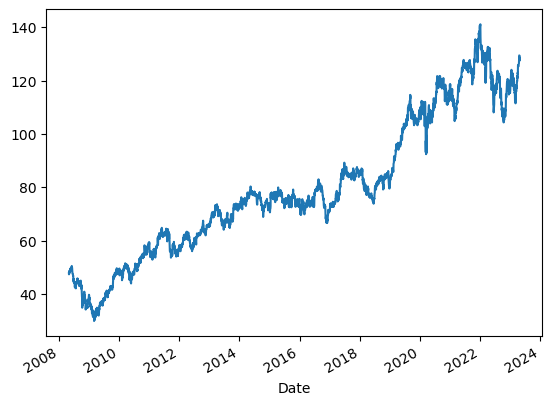

In [6]:
sp_df_15["Close"].plot()

In [7]:
len(sp_df_15)

3775

In [8]:
np.random.seed(123)
results_2h_5f = pipeline_feature_selection(sp_df_2, 2, 5)
results_2h_15f = pipeline_feature_selection(sp_df_2, 2, 15)
results_2h_30f = pipeline_feature_selection(sp_df_2, 2, 30)
results_2h_60f = pipeline_feature_selection(sp_df_2, 2, 60)

# results_5h_5f = pipeline_feature_selection(sp_df_5, 5, 5)
# results_5h_15f = pipeline_feature_selection(sp_df_5, 5, 15)
# results_5h_30f = pipeline_feature_selection(sp_df_5, 5, 30)
# results_5h_60f = pipeline_feature_selection(sp_df_5, 5, 60)

# results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
# results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
# results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
# results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(306, 30) (132, 30)
(306, 1) (132, 1)
H =  2

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(299, 30) (129, 30)
(299, 1) (129, 1)
H =  2

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(289, 30) (124, 30)
(289, 1) (124, 1)
H =  2

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 f

[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11,

H =  2

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.71000000000

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.0s
[CV] END C

In [9]:
results_5h_5f = pipeline_feature_selection(sp_df_5, 5, 5)
results_5h_15f = pipeline_feature_selection(sp_df_5, 5, 15)
results_5h_30f = pipeline_feature_selection(sp_df_5, 5, 30)
results_5h_60f = pipeline_feature_selection(sp_df_5, 5, 60)

# results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
# results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
# results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
# results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(835, 30) (359, 30)
(835, 1) (359, 1)
H =  5

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.000

[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.

[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s

(828, 30) (356, 30)
(828, 1) (356, 1)
H =  5

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[C

[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear;

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11,

Fitting 10 folds for each of 20 candidates, totalling 200 fits
(818, 30) (351, 30)
(818, 1) (351, 1)
H =  5

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.20000000000000

  0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ............

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=r

(797, 30) (342, 30)
(797, 1) (342, 1)
H =  5

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.945e+01, tolerance: 1.933e+00
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.845e+01, tolerance: 2.487e+00
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, m

[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ...................

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samp

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [10]:

results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(1717, 30) (736, 30)
(1717, 1) (736, 1)
H =  10

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, k

[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[

[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0sFitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=1, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total 

(1710, 30) (733, 30)
(1710, 1) (733, 1)
H =  10

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total 

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.1999999

Fitting 10 folds for each of 20 candidates, totalling 200 fits
(1699, 30) (729, 30)
(1699, 1) (729, 1)
H =  10

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......C=2.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; 

Fitting 10 folds for each of 20 candidates, totalling 200 fits

[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstra


[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time

Fitting 10 folds for each of 20 candidates, totalling 200 fits
(1678, 30) (720, 30)
(1678, 1) (720, 1)
H =  10

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6

[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END .......C=0.30000000000000004, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END .......C=0.30000000000000004, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END .......C=0.30000000000000004, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END .......C=0.30000000000000004, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .......

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.4

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [11]:
results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(2597, 30) (1114, 30)
(2597, 1) (1114, 1)
H =  15

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=2.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.1s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.1s
[CV] END ......C=0.8, gamma=8.5999

[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.1s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s


[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=0.2, gamma=5.6000000000000005, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.1s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV]

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[

(2590, 30) (1111, 30)
(2590, 1) (1111, 1)
H =  15

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.1s
[CV] END ......C=3.1, gamma=8.399999999999988, k

0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.1s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..............

[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=

[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END boot

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(2580, 30) (1106, 30)
(2580, 1) (1106, 1)
H =  15

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.1s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale

Fitting 10 folds for each of 20 candidates, totalling 200 fits
000001, kernel=rbf; total time=   0.1s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.2s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.2s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.2s
[CV] END C=1.7000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.0s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=r

[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_sam

[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.1s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.1s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.1s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END .......

[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.1s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ...................

Fitting 10 folds for each of 20 candidates, totalling 200 fits
(2559, 30) (1097, 30)
(2559, 1) (1097, 1)
H =  15

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+01, tolerance: 1.328e+00
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+01, tolerance: 2.160e+00
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01,

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.616e+00, tolerance: 4.377e+00
  model = cd_fast.enet_coordinate_descent(


tal time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.2s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.2s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.1s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.2s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.2s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.3s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.4s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.4s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total

[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.1s
[CV] END .........C=0.1, gamma=6.800000000000002, kernel=rbf; total time=   0.1s
[CV] END .........C=0.1, gamma=6.80000000000000

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [12]:
import pandas as pd

def create_results_dataframe(results, h, f):
    data = []
    columns = [
        "Model", "Historical data", "Forecast", "Mean Residual",
        "Train MAPE (Biased)", "Test MAPE (Biased)",
        "Train MAPE (Unbiased)", "Test MAPE (Unbiased)",
        "Train RMSE (Biased)", "Test RMSE (Biased)",
        "Train RMSE (Unbiased)", "Test RMSE (Unbiased)", "MAPE zero residuals val", "std_ratio_test", "std_ratio_val", "Ranking"
    ]
    
    for i in range(len(results["model"])):
        model = results["model"][i]
        mean_residual = results["mean residual"][i]
        train_mape_biased = results["train MAPE"][i]
        test_mape_biased = results["test MAPE"][i]
        train_mape_unbiased = results['MAPE zero residuals train'][i]
        test_mape_unbiased = results['MAPE zero residuals test'][i]
        train_rmse_biased = results["train RMSE"][i]
        test_rmse_biased = results["test RMSE"][i]
        train_rmse_unbiased = results['RMSE zero residuals train'][i]
        test_rmse_unbiased = results['RMSE zero residuals test'][i]
        val_mape = results["MAPE zero residuals val"][i]
        std_r_val = results["std_ratio_val"]
        std_r_test = results["std_ratio_test"]
        features = results["ranking"]
        row = [
            model, h, f, mean_residual,
            train_mape_biased, test_mape_biased,
            train_mape_unbiased, test_mape_unbiased,
            train_rmse_biased, test_rmse_biased,
            train_rmse_unbiased, test_rmse_unbiased, val_mape, std_r_val, std_r_test, features
        ]
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    lower_mape_unbiased = df["Test MAPE (Unbiased)"].min()
    lower_mape_val = df["MAPE zero residuals val"].min()
    lower_rmse_unbiased = df["Test RMSE (Unbiased)"].min()

    # Find the models with the lowest MAPE and RMSE values
    best_mape_model = df[df["Test MAPE (Unbiased)"] == lower_mape_unbiased]["Model"].iloc[0]
    best_mape_model_val = df[df["MAPE zero residuals val"] == lower_mape_val]["Model"].iloc[0]
    best_rmse_model = df[df["Test RMSE (Unbiased)"] == lower_rmse_unbiased]["Model"].iloc[0]
    
    print(f"Best model based on lower MAPE test unbiased: {best_mape_model}")
    print(f"The Lowest MAPE test unbiased: {round(lower_mape_unbiased,5)}")
    print(f"STD ratio test: {round(std_r_test, 5)}")
    print()
    print()
    print(f"Best model based on lower MAPE val unbiased: {best_mape_model_val}")
    print(f"The Lowest MAPE val unbiased: {round(lower_mape_val,5)}")
    print(f"STD ratio val: {round(std_r_val,5)}")
    print()
    print()
    
    return df

# Example usage
# Replace 'results', 'h', and 'f' with your actual data
results_df_2_5 = create_results_dataframe(results_2h_5f, 2, 5)
results_df_2_5 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.019
STD ratio test: 0.76332


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.01841
STD ratio val: 0.76571


Best model based on lower MAPE test unbiased: Lasso REgularization
The Lowest MAPE test unbiased: 0.0672
STD ratio test: 0.68827


Best model based on lower MAPE val unbiased: Lasso REgularization
The Lowest MAPE val unbiased: 0.07307
STD ratio val: 0.65959




In [13]:
def create_results_dataframe(results, h, f):
    data = []
    columns = [
        "Model", "Historical data", "Forecast", "Mean Residual",
        "Train MAPE (Biased)", "Test MAPE (Biased)",
        "Train MAPE (Unbiased)", "Test MAPE (Unbiased)",
        "Train RMSE (Biased)", "Test RMSE (Biased)",
        "Train RMSE (Unbiased)", "Test RMSE (Unbiased)", "MAPE zero residuals val", "std_ratio_test", "std_ratio_val", "ranking"
    ]
    
    for i in range(len(results["model"])):
        model = results["model"][i]
        mean_residual = results["mean residual"][i]
        train_mape_biased = results["train MAPE"][i]
        test_mape_biased = results["test MAPE"][i]
        train_mape_unbiased = results['MAPE zero residuals train'][i]
        test_mape_unbiased = results['MAPE zero residuals test'][i]
        train_rmse_biased = results["train RMSE"][i]
        test_rmse_biased = results["test RMSE"][i]
        train_rmse_unbiased = results['RMSE zero residuals train'][i]
        test_rmse_unbiased = results['RMSE zero residuals test'][i]
        val_mape = results["MAPE zero residuals val"][i]
        std_r_val = results["std_ratio_val"]
        std_r_test = results["std_ratio_test"]
        ranking = results["ranking"]  # Get the ranking information
        row = [
            model, h, f, mean_residual,
            train_mape_biased, test_mape_biased,
            train_mape_unbiased, test_mape_unbiased,
            train_rmse_biased, test_rmse_biased,
            train_rmse_unbiased, test_rmse_unbiased, val_mape, std_r_val,std_r_test,ranking
        ]
        data.append(row)
        
    
    df = pd.DataFrame(data, columns=columns)
    lower_mape_unbiased = df["Test MAPE (Unbiased)"].min()
    lower_mape_val = df["MAPE zero residuals val"].min()
    lower_rmse_unbiased = df["Test RMSE (Unbiased)"].min()

# Find the models with the lowest MAPE and RMSE values
    best_mape_model = df[df["Test MAPE (Unbiased)"] == lower_mape_unbiased]["Model"].iloc[0]
    best_mape_model_val = df[df["MAPE zero residuals val"] == lower_mape_val]["Model"].iloc[0]
    best_rmse_model = df[df["Test RMSE (Unbiased)"] == lower_rmse_unbiased]["Model"].iloc[0]
    print(f"Best model based on lower MAPE test unbiased: {best_mape_model}")
    print(f"The Lowest MAPE test unbiased: {round(lower_mape_unbiased,5)}")
    print(f"STD ratio test: {round(std_r_test, 5)}")
    print()
    print()
    print(f"Best model based on lower MAPE val unbiased: {best_mape_model_val}")
    print(f"The Lowest MAPE val unbiased: {round(lower_mape_val,5)}")
    print(f"STD ratio val: {round(std_r_val,5)}")
    print()
    print()
#     print(df["ranking"])
    
    return df

# Example usage
# Replace 'results', 'h', and 'f' with your actual data
results_df_2_5 = create_results_dataframe(results_2h_5f, 2, 5)
#results_df_2_5 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.019
STD ratio test: 0.76332


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.01841
STD ratio val: 0.76571




In [14]:
results_2h_5f['MAPE zero residuals val']

[0.018473363549670364,
 0.033957844593252504,
 0.018473363549670364,
 0.026060369565158836,
 0.01908234649769943,
 0.01841401551396519,
 0.025145933656138205]

In [15]:
results_2h_60f['MAPE zero residuals val']

[0.07492301959577552,
 0.08809723367422391,
 0.07307268372104346,
 0.08336304063508898,
 0.10053929505284447,
 0.10903238103635103,
 0.08453733468475036]

In [16]:
results_df_2_15 = create_results_dataframe(results_2h_15f, 2, 15)

Best model based on lower MAPE test unbiased: Random Forest Regresssor
The Lowest MAPE test unbiased: 0.03266
STD ratio test: 0.87381


Best model based on lower MAPE val unbiased: Random Forest Regresssor
The Lowest MAPE val unbiased: 0.03281
STD ratio val: 0.86141




In [17]:
results_df_2_30 = create_results_dataframe(results_2h_30f, 2, 30)


Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.06072
STD ratio test: 0.82466


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.05686
STD ratio val: 0.81976




In [18]:
results_df_2_60 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: Lasso REgularization
The Lowest MAPE test unbiased: 0.0672
STD ratio test: 0.68827


Best model based on lower MAPE val unbiased: Lasso REgularization
The Lowest MAPE val unbiased: 0.07307
STD ratio val: 0.65959




In [19]:
results_df_5_5 = create_results_dataframe(results_5h_5f, 5, 5)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.02147
STD ratio test: 1.37478


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.0175
STD ratio val: 1.06456




In [20]:
results_df_5_15 = create_results_dataframe(results_5h_15f, 5, 15)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.04027
STD ratio test: 1.52177


Best model based on lower MAPE val unbiased: Random Forest Regresssor
The Lowest MAPE val unbiased: 0.03106
STD ratio val: 1.29374




In [21]:
results_df_5_30 = create_results_dataframe(results_5h_30f, 5, 30)

Best model based on lower MAPE test unbiased: Random Forest Regresssor
The Lowest MAPE test unbiased: 0.05465
STD ratio test: 1.57504


Best model based on lower MAPE val unbiased: Lasso REgularization
The Lowest MAPE val unbiased: 0.04379
STD ratio val: 1.26482




In [22]:
results_df_5_60 = create_results_dataframe(results_5h_60f, 5, 60)

Best model based on lower MAPE test unbiased: Lasso REgularization
The Lowest MAPE test unbiased: 0.0692
STD ratio test: 1.37607


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.037
STD ratio val: 0.90495




In [23]:
results_df_10_5 = create_results_dataframe(results_10h_5f, 10, 5)
results_df_10_5

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.0184
STD ratio test: 1.51605


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.01766
STD ratio val: 1.37026




,Model,Historical data,Forecast,Mean Residual,Train MAPE (Biased),Test MAPE (Biased),Train MAPE (Unbiased),Test MAPE (Unbiased),Train RMSE (Biased),Test RMSE (Biased),Train RMSE (Unbiased),Test RMSE (Unbiased),MAPE zero residuals val,std_ratio_test,std_ratio_val,ranking
0,Naive,10,5,1.134828e-01,0.016330,0.018474,0.016279,0.018405,1.865590,2.827171,1.862135,2.823347,0.017722,1.370263,1.516047,"[[60_rolling_mean, upper_band, middle_band, lo..."
1,Linear regression,10,5,9.568940e-03,0.016214,0.018965,0.016216,0.018977,1.824319,2.857776,1.824294,2.858564,0.019454,1.370263,1.516047,"[[60_rolling_mean, upper_band, middle_band, lo..."
2,Lasso REgularization,10,5,-4.138280e-17,0.016279,0.018405,0.016279,0.018405,1.862135,2.823347,1.862135,2.823347,0.017722,1.370263,1.516047,"[[60_rolling_mean, upper_band, middle_band, lo..."
3,Ridge Regularization,10,5,6.621249e-17,0.016213,0.018989,0.016213,0.018989,1.824148,2.859043,1.824148,2.859043,0.019445,1.370263,1.516047,"[[60_rolling_mean, upper_band, middle_band, lo..."
4,Random Forest Regresssor,10,5,7.866550e-03,0.016039,0.028246,0.016038,0.028293,1.784974,4.034542,1.784957,4.040177,0.029911,1.370263,1.516047,"[[60_rolling_mean, upper_band, middle_band, lo..."
5,"SVR, kernel = rbf",10,5,4.519757e-02,0.014430,0.018382,0.014425,0.018398,1.720772,2.825244,1.720178,2.824773,0.017658,1.370263,1.516047,"[[60_rolling_mean, upper_band, middle_band, lo..."
6,"SVR, kernel = linear",10,5,5.514178e-02,0.016107,0.018644,0.016108,0.018647,1.837740,2.856094,1.836912,2.853292,0.018289,1.370263,1.516047,"[[60_rolling_mean, upper_band, middle_band, lo..."


In [24]:
results_df_10_15 = create_results_dataframe(results_10h_15f, 10, 15)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.03334
STD ratio test: 1.7652


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.03585
STD ratio val: 1.75607




In [25]:
results_df_10_30 = create_results_dataframe(results_10h_30f, 10, 30)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.0469
STD ratio test: 1.86626


Best model based on lower MAPE val unbiased: Linear regression
The Lowest MAPE val unbiased: 0.045
STD ratio val: 1.7345




In [26]:
results_df_10_60 = create_results_dataframe(results_10h_60f, 10, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.05413
STD ratio test: 1.67397


Best model based on lower MAPE val unbiased: Linear regression
The Lowest MAPE val unbiased: 0.03989
STD ratio val: 1.17714




In [27]:
results_df_15_5 = create_results_dataframe(results_15h_5f, 15, 5)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.01834
STD ratio test: 1.91274


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.01777
STD ratio val: 1.75851




In [28]:
results_df_15_15 = create_results_dataframe(results_15h_15f, 15, 15)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.03242
STD ratio test: 2.02695


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.03633
STD ratio val: 2.14803




In [29]:
results_df_15_30 = create_results_dataframe(results_15h_30f, 15, 30)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.04573
STD ratio test: 2.06247


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.04746
STD ratio val: 2.08417




In [30]:
results_df_15_60 = create_results_dataframe(results_15h_60f, 15, 60)
results_df_15_60

Best model based on lower MAPE test unbiased: Linear regression
The Lowest MAPE test unbiased: 0.05858
STD ratio test: 1.81399


Best model based on lower MAPE val unbiased: Naive
The Lowest MAPE val unbiased: 0.05226
STD ratio val: 1.37016




,Model,Historical data,Forecast,Mean Residual,Train MAPE (Biased),Test MAPE (Biased),Train MAPE (Unbiased),Test MAPE (Unbiased),Train RMSE (Biased),Test RMSE (Biased),Train RMSE (Unbiased),Test RMSE (Unbiased),MAPE zero residuals val,std_ratio_test,std_ratio_val,ranking
0,Naive,15,60,9.490113e-01,0.060775,0.060283,0.058627,0.059071,4.520481,8.267452,4.419743,8.088320,0.052257,1.370164,1.813986,"[[Open, High, Low, Close, Adj Close, month, H-..."
1,Linear regression,15,60,-2.043609e-15,0.054299,0.058580,0.054299,0.058580,4.169000,8.301520,4.169000,8.301520,0.059136,1.370164,1.813986,"[[Open, High, Low, Close, Adj Close, month, H-..."
2,Lasso REgularization,15,60,2.221314e-17,0.058561,0.059057,0.058561,0.059057,4.415679,8.089209,4.415679,8.089209,0.052610,1.370164,1.813986,"[[Open, High, Low, Close, Adj Close, month, H-..."
3,Ridge Regularization,15,60,-7.996729e-16,0.054426,0.058652,0.054426,0.058652,4.176065,8.320071,4.176065,8.320071,0.059949,1.370164,1.813986,"[[Open, High, Low, Close, Adj Close, month, H-..."
4,Random Forest Regresssor,15,60,-7.137499e-03,0.055097,0.067346,0.055095,0.067321,4.075622,9.344058,4.075616,9.340395,0.073948,1.370164,1.813986,"[[Open, High, Low, Close, Adj Close, month, H-..."
5,"SVR, kernel = rbf",15,60,3.378961e-01,0.027745,0.058769,0.029130,0.059096,2.728248,8.052638,2.707243,8.090975,0.052326,1.370164,1.813986,"[[Open, High, Low, Close, Adj Close, month, H-..."
6,"SVR, kernel = linear",15,60,4.228300e-01,0.054443,0.060567,0.054314,0.062051,4.215850,8.594823,4.194593,8.803310,0.067290,1.370164,1.813986,"[[Open, High, Low, Close, Adj Close, month, H-..."


In [34]:
import pandas as pd

# Create a list of your DataFrame names
dataframe_names = ["results_df_2_5", "results_df_2_15", "results_df_2_30", "results_df_2_60",
                   "results_df_5_5", "results_df_5_15", "results_df_5_30", "results_df_5_60",
                   "results_df_10_5", "results_df_10_15", "results_df_10_30", "results_df_10_60",
                   "results_df_15_5", "results_df_15_15", "results_df_15_30", "results_df_15_60"]

combined_df = pd.DataFrame()

# Iterate through the DataFrame names and concatenate them
for df_name in dataframe_names:
    df = globals()[df_name]  # Fetch the DataFrame by its name
    combined_df = pd.concat([combined_df, df])

# Extract only the desired columns
columns_to_keep = ["Model","Historical data", "Forecast","Mean Residual","Test MAPE (Biased)",  "Test MAPE (Unbiased)", "MAPE zero residuals val","ranking"]
combined_df = combined_df[columns_to_keep]


In [35]:
combined_df.head(30)

,Model,Historical data,Forecast,Mean Residual,Test MAPE (Biased),Test MAPE (Unbiased),MAPE zero residuals val,ranking
0,Naive,2,5,-3.183333e-01,0.018160,0.019069,0.018473,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
1,Linear regression,2,5,-1.604526e-14,0.029951,0.029951,0.033958,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
2,Lasso REgularization,2,5,-1.393221e-16,0.019069,0.019069,0.018473,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
3,Ridge Regularization,2,5,3.250849e-16,0.023906,0.023906,0.026060,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
4,Random Forest Regresssor,2,5,-1.399536e-02,0.019184,0.019138,0.019082,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
5,"SVR, kernel = rbf",2,5,9.479105e-02,0.018719,0.019005,0.018414,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
6,"SVR, kernel = linear",2,5,8.250426e-02,0.023407,0.023860,0.025146,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
0,Naive,2,15,-9.198662e-01,0.039149,0.042002,0.038098,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
1,Linear regression,2,15,8.412446e-14,0.083371,0.083371,0.097598,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."
2,Lasso REgularization,2,15,-1.901118e-16,0.042002,0.042002,0.038098,"[[month, 30_rolling_mean, 60_rolling_mean, 7_r..."


In [36]:
combined_df.to_csv('combined_results_NSRGY_after_FS_n.csv', index=True)